# Chinese Stock Market Analysis

In [11]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from datetime import datetime

# Load data
with open('/Users/edwardju/Downloads/chinese-stock-market/data/industry_sentiment.json', 'r') as f:
    sentiment_data = json.load(f)

stock_data = pd.read_csv('/Users/edwardju/Downloads/chinese-stock-market/data/analysis_ready_data.csv')
stock_data['Trddt'] = pd.to_datetime(stock_data['Trddt'])

# Set date range
start_date = pd.to_datetime('2015-01-01')
end_date = pd.to_datetime('2023-12-01')
analysis_data = stock_data[(stock_data['Trddt'] >= start_date) & (stock_data['Trddt'] <= end_date)]

## Sentiment Score Distribution

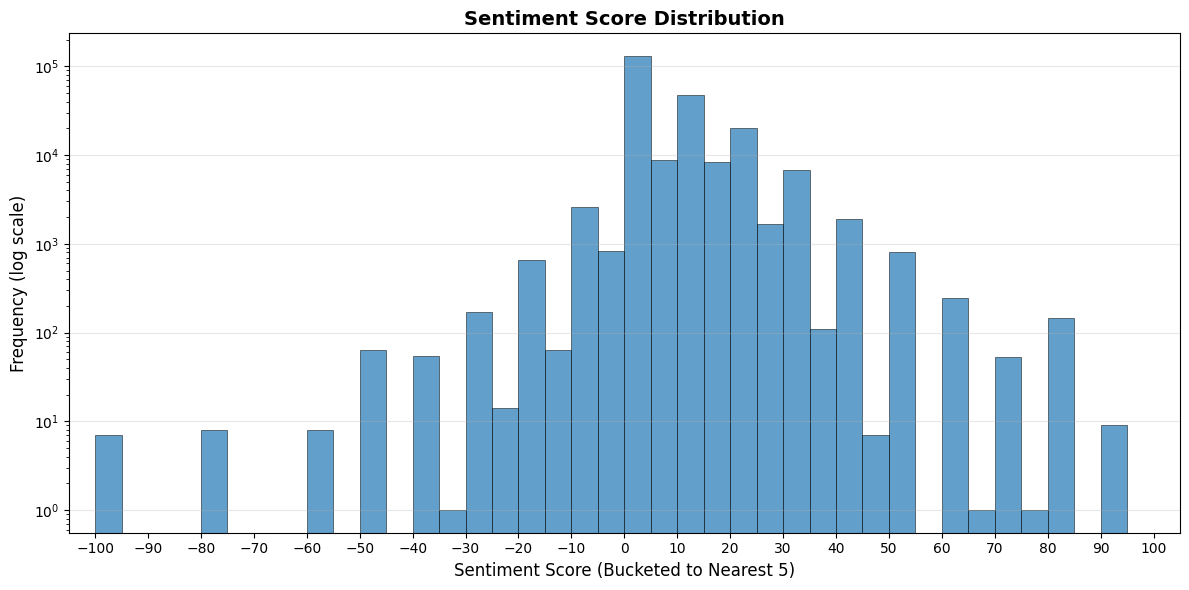

In [17]:
# Extract all sentiment scores and bucket them
all_scores = []
for date_str, day_data in sentiment_data.items():
    date = pd.to_datetime(date_str, format='%Y%m%d')
    if start_date <= date <= end_date:
        for industry, score_data in day_data['results'].items():
            all_scores.append(score_data['score'])

# Round to nearest multiple of 5 for cleaner visualization
bucketed_scores = [round(score / 5) * 5 for score in all_scores]

# Count frequencies
from collections import Counter
score_counts = Counter(bucketed_scores)
buckets = sorted(score_counts.keys())
frequencies = [score_counts[b] for b in buckets]

plt.figure(figsize=(12, 6))
# Use align='edge' and set width=5 to remove gaps
plt.bar(buckets, frequencies, width=5, edgecolor='black', linewidth=0.5, alpha=0.7, align='edge')
plt.xlabel('Sentiment Score (Bucketed to Nearest 5)', fontsize=12)
plt.ylabel('Frequency (log scale)', fontsize=12)
plt.title('Sentiment Score Distribution', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.xticks(range(-100, 105, 10))
plt.grid(True, alpha=0.3, axis='y')
plt.xlim(-105, 105)
plt.tight_layout()
plt.savefig('results/sentiment_distribution.png', dpi=150)
plt.show()

## Sentiment-Return Correlation

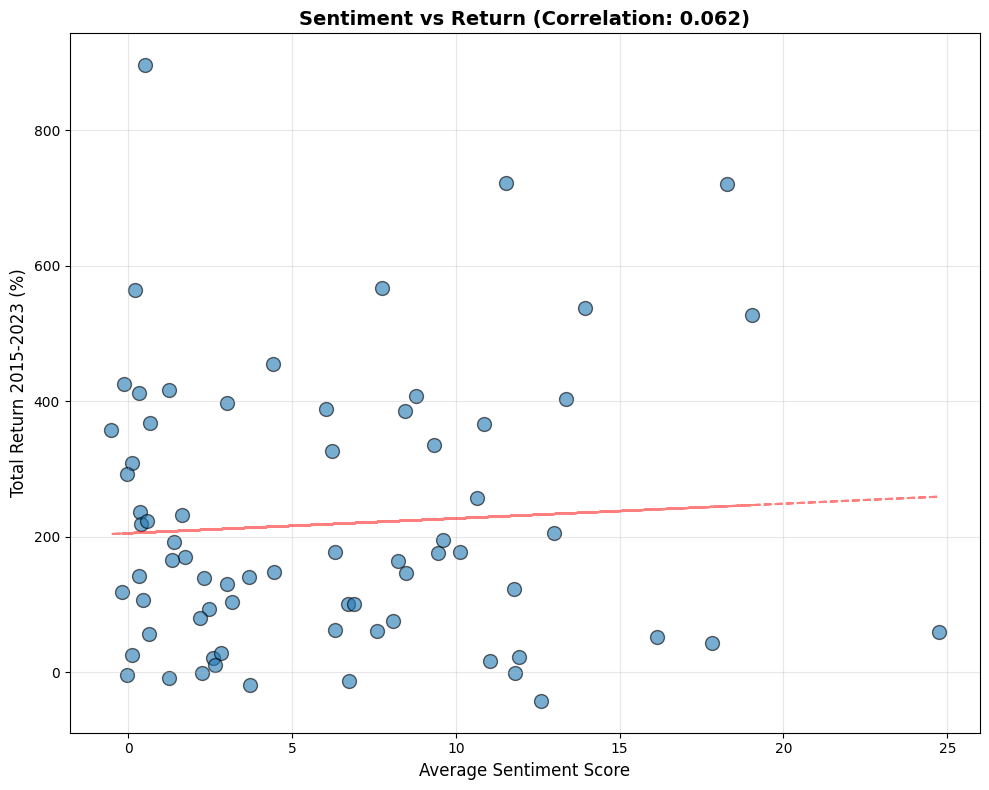

In [13]:
# Calculate industry returns and average sentiment
industry_metrics = {}

for industry in analysis_data['Nindnme_en'].dropna().unique():
    ind_data = analysis_data[analysis_data['Nindnme_en'] == industry]
    
    daily_returns = ind_data.groupby('Trddt').apply(
        lambda x: (x['Dretwd'] * x['Dsmvtll']).sum() / x['Dsmvtll'].sum() 
        if x['Dsmvtll'].sum() > 0 else 0,
        include_groups=False
    )
    
    if len(daily_returns) > 100:
        total_return = (1 + daily_returns).prod() - 1
        
        sentiment_scores = []
        for date_str, day_data in sentiment_data.items():
            date = pd.to_datetime(date_str, format='%Y%m%d')
            if start_date <= date <= end_date:
                if industry in day_data['results']:
                    sentiment_scores.append(day_data['results'][industry]['score'])
        
        if sentiment_scores:
            industry_metrics[industry] = {
                'return': total_return * 100,
                'avg_sentiment': np.mean(sentiment_scores)
            }

df = pd.DataFrame.from_dict(industry_metrics, orient='index')
correlation = df['avg_sentiment'].corr(df['return'])

plt.figure(figsize=(10, 8))
plt.scatter(df['avg_sentiment'], df['return'], s=100, alpha=0.6, edgecolors='black')
z = np.polyfit(df['avg_sentiment'], df['return'], 1)
p = np.poly1d(z)
plt.plot(df['avg_sentiment'], p(df['avg_sentiment']), 'r--', alpha=0.5)

plt.xlabel('Average Sentiment Score', fontsize=12)
plt.ylabel('Total Return 2015-2023 (%)', fontsize=12)
plt.title(f'Sentiment vs Return (Correlation: {correlation:.3f})', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('results/sentiment_return_correlation.png', dpi=150)
plt.show()

## Industry Performance Rankings

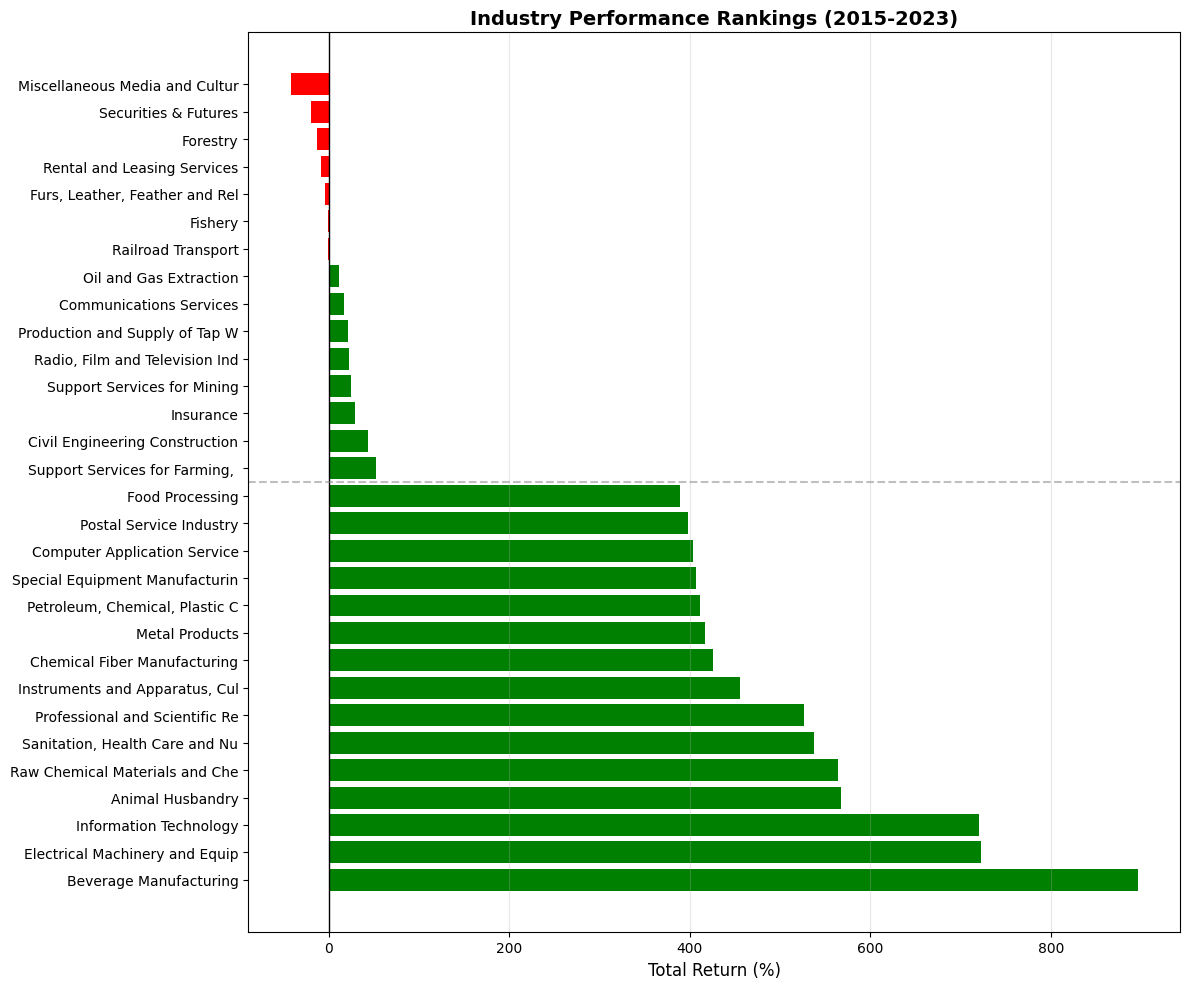

In [14]:
sorted_industries = sorted(industry_metrics.items(), key=lambda x: x[1]['return'], reverse=True)
top_15 = sorted_industries[:15]
bottom_15 = sorted_industries[-15:]

plt.figure(figsize=(12, 10))

plot_data = top_15 + bottom_15
names = [ind[:30] for ind, _ in plot_data]
returns = [metrics['return'] for _, metrics in plot_data]
colors = ['green' if r > 0 else 'red' for r in returns]

bars = plt.barh(range(len(names)), returns, color=colors)
plt.yticks(range(len(names)), names)
plt.xlabel('Total Return (%)', fontsize=12)
plt.title('Industry Performance Rankings (2015-2023)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linewidth=1)

plt.axhline(y=14.5, color='gray', linestyle='--', alpha=0.5)

plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('results/industry_performance.png', dpi=150)
plt.show()

## Overall Market Performance

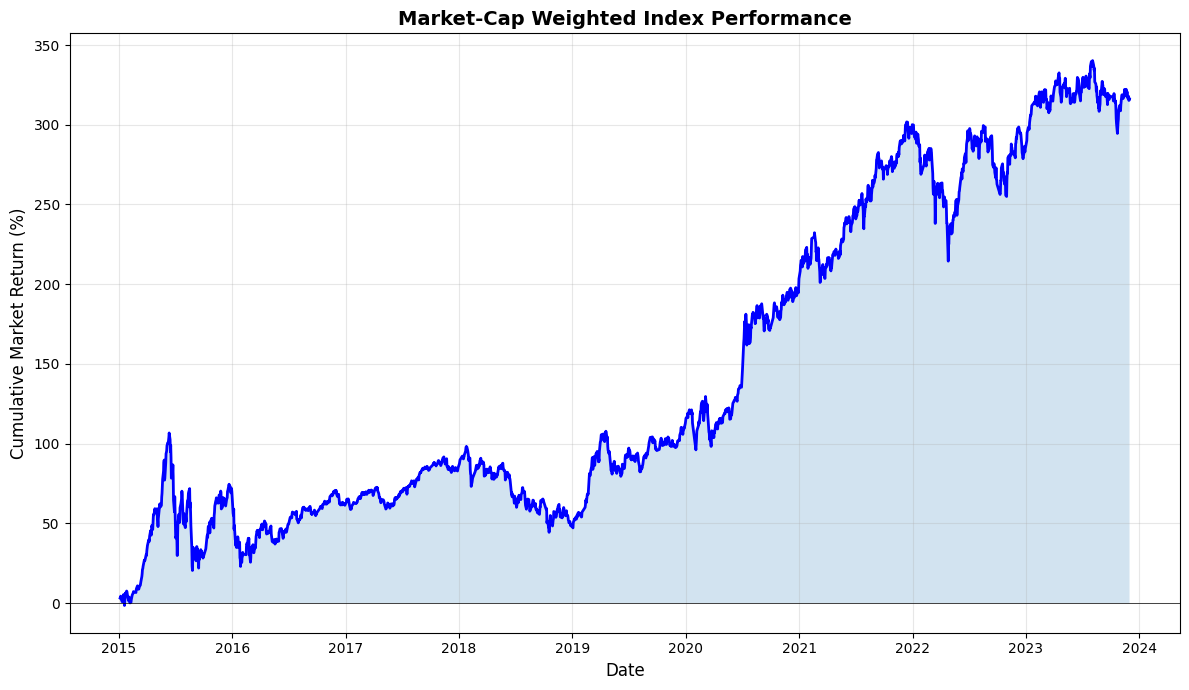

In [15]:
market_returns = analysis_data.groupby('Trddt').apply(
    lambda x: (x['Dretwd'] * x['Dsmvtll']).sum() / x['Dsmvtll'].sum()
    if x['Dsmvtll'].sum() > 0 else 0,
    include_groups=False
)

cumulative = (1 + market_returns).cumprod() - 1

plt.figure(figsize=(12, 7))
plt.plot(cumulative.index, cumulative * 100, linewidth=2, color='blue')
plt.fill_between(cumulative.index, 0, cumulative * 100, alpha=0.2)

plt.axhline(y=0, color='black', linewidth=0.5)

final_return = cumulative.iloc[-1] * 100

plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Market Return (%)', fontsize=12)
plt.title('Market-Cap Weighted Index Performance', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('results/market_performance.png', dpi=150)
plt.show()

In [18]:
# Market statistics
market_df = pd.DataFrame({'date': cumulative.index, 'return': market_returns.values})
market_df['cumulative'] = (1 + market_df['return']).cumprod() - 1

# Basic metrics
total_return = market_df['cumulative'].iloc[-1]
n_days = len(market_df)
years = n_days / 252
annualized = (1 + total_return) ** (1/years) - 1
daily_vol = market_df['return'].std()
annual_vol = daily_vol * np.sqrt(252)
sharpe = annualized / annual_vol

# Drawdown calculation
running_max = (1 + market_df['cumulative']).expanding().max()
drawdown = ((1 + market_df['cumulative']) - running_max) / running_max
max_dd = drawdown.min()
avg_dd = drawdown[drawdown < 0].mean()

# Win rate
win_days = (market_df['return'] > 0).sum()
loss_days = (market_df['return'] <= 0).sum()
win_rate = win_days / len(market_df)

# Best/worst periods
best_day = market_df['return'].max()
worst_day = market_df['return'].min()
best_month = market_df.set_index('date')['return'].rolling(20).sum().max()
worst_month = market_df.set_index('date')['return'].rolling(20).sum().min()

print(f"Total Return: {total_return*100:.1f}%")
print(f"Annualized: {annualized*100:.1f}%")
print(f"Volatility: {annual_vol*100:.1f}%")
print(f"Sharpe Ratio: {sharpe:.3f}")
print(f"Max Drawdown: {max_dd*100:.1f}%")
print(f"Average Drawdown: {avg_dd*100:.1f}%")
print(f"Win Rate: {win_rate*100:.1f}% ({win_days} up days, {loss_days} down days)")
print(f"Best Day: {best_day*100:.2f}%")
print(f"Worst Day: {worst_day*100:.2f}%")
print(f"Best Month: {best_month*100:.1f}%") 
print(f"Worst Month: {worst_month*100:.1f}%")

Total Return: 316.2%
Annualized: 18.0%
Volatility: 23.4%
Sharpe Ratio: 0.770
Max Drawdown: -41.7%
Average Drawdown: -11.9%
Win Rate: 55.3% (1199 up days, 970 down days)
Best Day: 7.84%
Worst Day: -9.42%
Best Month: 28.7%
Worst Month: -41.4%
